[*********************100%***********************]  1 of 1 completed


Fetching news for ETH-USD (crypto)
Fetching social media trends for ETH-USD


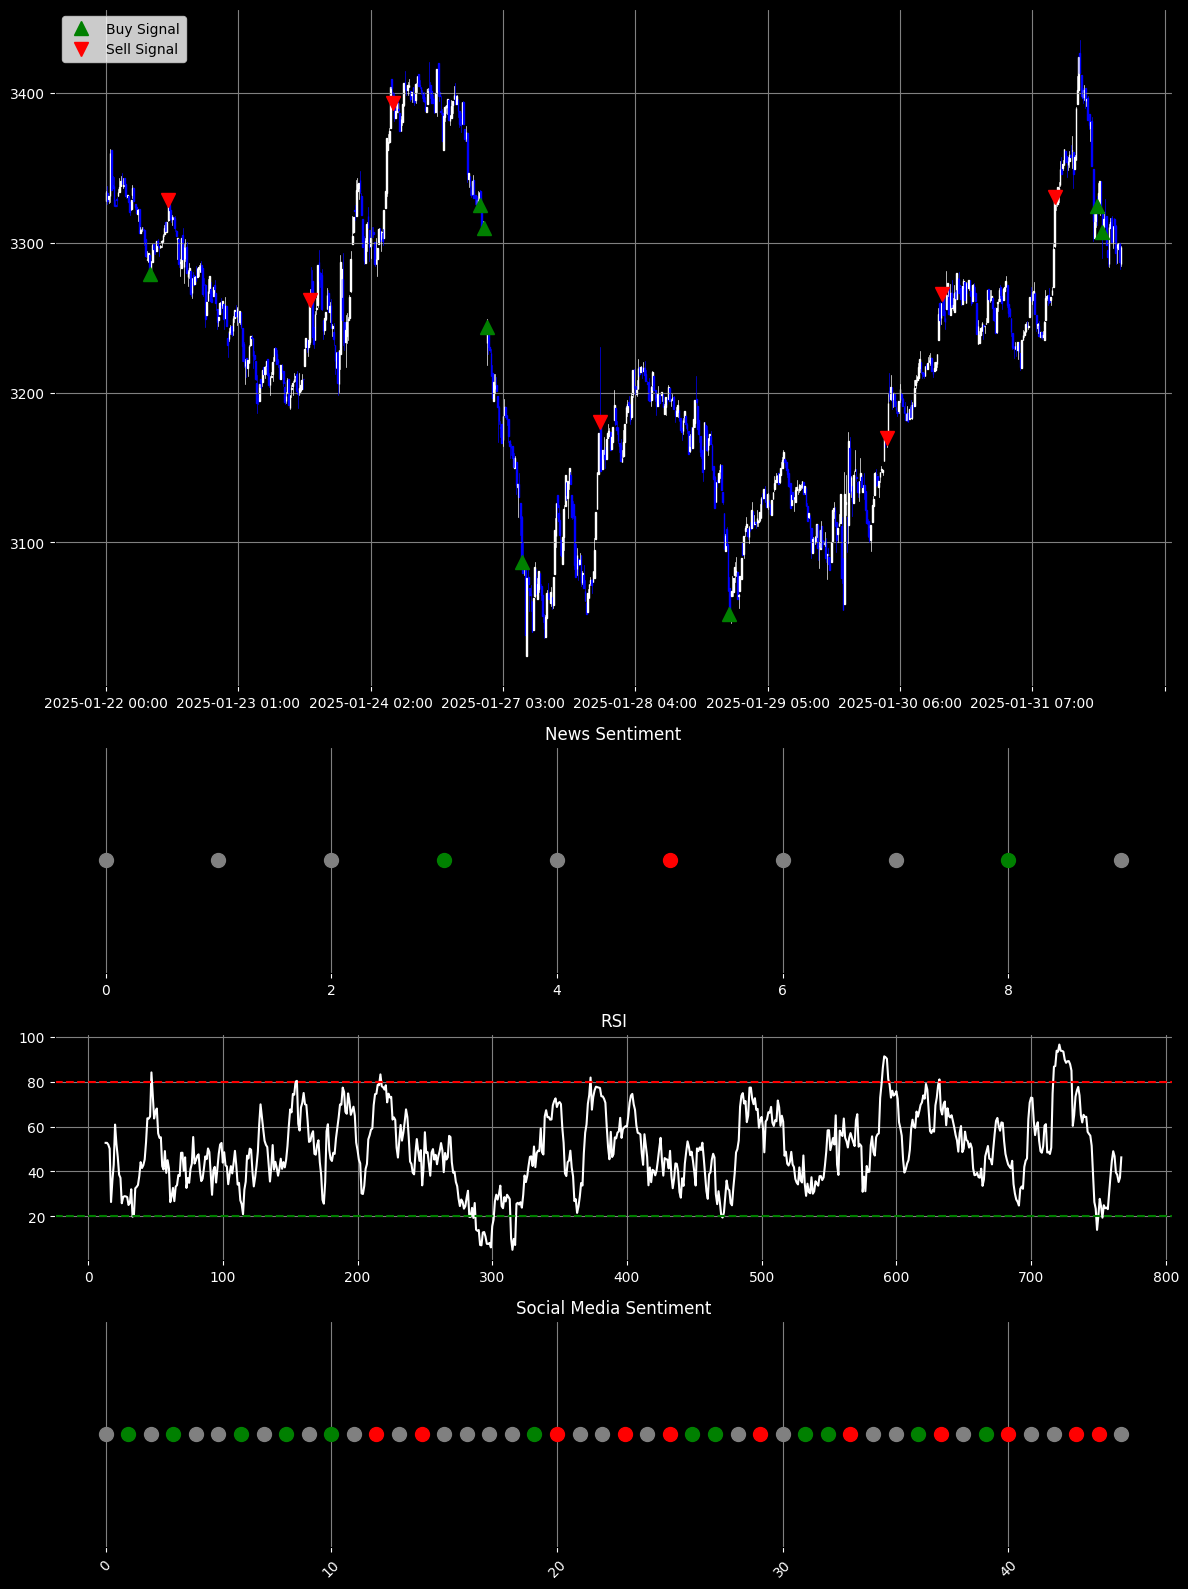

News: Ethereum Founder Keeps Bitcoin 
Sentiment: Neutral

News: Bitcoin, XRP, Dogecoin Pull Back On Trump Tariff Announcement, Ethereum Hanging On 
Sentiment: Neutral

News: End of day Ethereum price (ETHUSD) forecast update - 31-01-2025 
Sentiment: Neutral

News: Top Ethereum Analysts Predict $4.5K Surge Amid Trump-Led Accumulation 
Sentiment: Positive

News: Ethereum (ETH) to $10K? Analyst Reveals When the Next Big Surge Might Happen! 
Sentiment: Neutral

Tweet: 🔝 dYdX Chain open interest: $320,316,118.82
🥇 - BTC-USD $110,731,131.87
🥈 - ETH-USD $87,382,577.37
🥉 - SOL-USD $35,569,969.31 
Sentiment: Neutral

Tweet: Boyco quant update - focusing on the major pools that have 0.9% of BERA allocated.

Currently: $228M in major pools TVL.  Of this:
- ~$71M in Infrared x Kodiak flagship volatile pools (ETH-BTC, ETH-USD, BTC-USD) incentivized at 4.2x
- Rest in stable, incentivized at 1.35-1.5x https://t.co/btx7Q93cvq 
Sentiment: Positive

Tweet: @ERC20_News @Dolomite_io @GMX_IO The integratio

In [30]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from datetime import datetime, timedelta
from GoogleNews import GoogleNews
from textblob import TextBlob
import tweepy
from colorama import Fore, Style, init
import time

init(autoreset=True)

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAM2fygEAAAAArGnwISuKPRJbldWWqAf1c2b%2BY9Q%3Doupmij2kfSBAzeh3OBcZLQrGuKfGDnZWsioQGQnRNRj2u7Zcvw'

client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

def detect_asset_type(ticker):
    if '-' in ticker:
        return 'crypto'
    elif len(ticker) == 6 and ticker.isupper():
        return 'forex'
    else:
        return 'stock'

def fetch_stock_news(ticker, asset_type):
    googlenews = GoogleNews(lang='en')
    if asset_type == 'crypto':
        googlenews.search(f"{ticker} cryptocurrency news")
    elif asset_type == 'forex':
        googlenews.search(f"{ticker} forex news")
    else:
        googlenews.search(f"{ticker} stock news")
    news_list = googlenews.get_texts()
    return news_list

def fetch_social_media_trends(ticker):
    query = f"{ticker} -is:retweet lang:en"
    tweets = []
    try:
        for tweet in tweepy.Paginator(client.search_recent_tweets, query=query, tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=100):
            tweets.append(tweet.text)
    except tweepy.TooManyRequests:
        print("Rate limit exceeded. Waiting for 15 minutes before retrying...")
        time.sleep(15 * 60)  # wait for 15 minutes
        return fetch_social_media_trends(ticker)  # retry fetching tweets
    return tweets

def analyze_sentiment(text_list):
    sentiment_scores = []
    
    for text in text_list:
        analysis = TextBlob(text)
        
        if analysis.sentiment.polarity > 0:
            sentiment_scores.append('Positive')
        elif analysis.sentiment.polarity == 0:
            sentiment_scores.append('Neutral')
        else:
            sentiment_scores.append('Negative')
    
    return sentiment_scores

def financial_rsi_bot(ticker):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=10)
    
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='15m')
    data.reset_index(inplace=True)
    data = data[data['Datetime'].dt.weekday < 5]
    data['Continuous_Index'] = range(len(data))
    
    ohlc_data = data[['Continuous_Index', 'Open', 'High', 'Low', 'Close']].values
    
    fig, (ax1, ax3, ax2, ax4) = plt.subplots(4, figsize=(12, 16), gridspec_kw={'height_ratios': [3, 1, 1, 1]}, facecolor='black')
    ax1.set_facecolor('black')
    ax3.set_facecolor('black')
    ax2.set_facecolor('black')
    ax4.set_facecolor('black')
    
    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='white', colordown='blue')
    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  
    def format_date(x, _):
        if x < 0 or x >= len(data):
            return ''
        return data['Datetime'].iloc[int(x)].strftime('%Y-%m-%d %H:%M')
    
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_date))
    plt.xticks(rotation=45, color='white')
    
    ax1.grid(True, color='gray')
    ax1.tick_params(axis='x', colors='white')
    ax1.tick_params(axis='y', colors='white')
    
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

    data['avg_volume'] = data['Volume'].rolling(window=14).mean()
    
    data['buy_signal'] = (data['RSI'] < 20) & (data['RSI'].shift(1) >= 20) 
    data['sell_signal'] = (data['RSI'] > 80) & (data['RSI'].shift(1) <= 80)
    
    ax2.set_title('RSI', color='white')
    ax2.plot(data['Continuous_Index'], data['RSI'], color='white')
    ax2.axhline(80, color='red', linestyle='--')
    ax2.axhline(20, color='green', linestyle='--')
    ax2.grid(True, color='gray')
    ax2.tick_params(axis='x', colors='white')
    ax2.tick_params(axis='y', colors='white')
    
    ax1.plot(data.loc[data['buy_signal'], 'Continuous_Index'], data.loc[data['buy_signal'], 'Close'], '^', markersize=10, color='green', label='Buy Signal')
    ax1.plot(data.loc[data['sell_signal'], 'Continuous_Index'], data.loc[data['sell_signal'], 'Close'], 'v', markersize=10, color='red', label='Sell Signal')
    
    ax1.legend()
    
    asset_type = detect_asset_type(ticker)
    print(f"Fetching news for {ticker} ({asset_type})")
    news_list = fetch_stock_news(ticker, asset_type)
    sentiment_scores = analyze_sentiment(news_list)
    
    sentiment_colors = {'Positive': 'green', 'Neutral': 'grey', 'Negative': 'red'}
    
    for i, (news, sentiment) in enumerate(zip(news_list, sentiment_scores)):
        ax3.plot(i, 1, 'o', color=sentiment_colors[sentiment], markersize=10)
    
    ax3.set_yticks([])
    ax3.set_title('News Sentiment', color='white')
    ax3.grid(True, color='gray')
    ax3.tick_params(axis='x', colors='white')
    ax3.tick_params(axis='y', colors='white')
    
    print(f"Fetching social media trends for {ticker}")
    social_media_list = fetch_social_media_trends(ticker)
    social_media_sentiment_scores = analyze_sentiment(social_media_list)
    
    for i, (tweet, sentiment) in enumerate(zip(social_media_list, social_media_sentiment_scores)):
        ax4.plot(i, 1, 'o', color=sentiment_colors[sentiment], markersize=10)
    
    ax4.set_yticks([])
    ax4.set_title('Social Media Sentiment', color='white')
    ax4.grid(True, color='gray')
    ax4.tick_params(axis='x', colors='white')
    ax4.tick_params(axis='y', colors='white')
    
    plt.tight_layout()
    plt.show()

    for news, sentiment in zip(news_list[:10], sentiment_scores[:10]):
        print(f"{Fore.YELLOW}News: {Style.RESET_ALL}{news} \n{Fore.CYAN}Sentiment: {sentiment}\n")
    
    for tweet, sentiment in zip(social_media_list[:10], social_media_sentiment_scores[:10]):
        print(f"{Fore.YELLOW}Tweet: {Style.RESET_ALL}{tweet} \n{Fore.CYAN}Sentiment: {sentiment}\n")

ticker = "ETH-USD"
financial_rsi_bot(ticker)